In [12]:
import numpy as np
import matplotlib.pyplot as plt
import graphlearning as gl
from scipy.optimize import minimize, LinearConstraint
import sklearn.datasets as datasets


Generate a sample of size 2 * n containing n data points from each class.
All data points are sampled from a dim-dimensional Gaussian.

[[3.1 3.6]
 [1.6 3.2]
 [2.6 2.4]
 [3.2 3.5]
 [3.7 2. ]
 [2.5 3.2]
 [2.7 1.4]
 [4.4 1.1]]
[0. 0. 0. 0. 1. 1. 1. 1.]


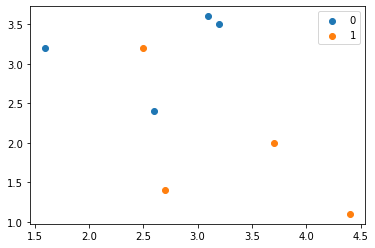

In [13]:
n = 4 # Sample size from each class
dim = 2
data = np.zeros((2 * n, dim))
mean1, cov1 = [2, 4], (1/2) * np.identity(dim)
mean2, cov2 = [4,2], (1/2) * np.identity(dim)
np.random.seed(1)
data[:n] = np.random.multivariate_normal(mean1, cov1, n)
np.random.seed(2)
data[n:] = np.random.multivariate_normal(mean2, cov2, n)

data = np.around(data, 1) #Round data to 1 decimal
#np.random.multivariate_normal([2,4], np.identity(dim), 10)
plt.scatter(data[:n, 0], data[:n, 1], label = '0')
plt.scatter(data[n:, 0], data[n:, 1], label = '1')
plt.legend()
print(data)

y = np.zeros(2*n)
y[n:] = 1
print(y)

In [14]:
a = np.arange(10).reshape(5,2)
b = np.random.randint(5, size=10).reshape(5,2)
print(a, b, np.inner(a,b), sep="\n")

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[[2 4]
 [4 4]
 [3 4]
 [2 3]
 [3 2]]
[[ 4  4  4  3  2]
 [16 20 18 13 12]
 [28 36 32 23 22]
 [40 52 46 33 32]
 [52 68 60 43 42]]


Calculate $$I[u] = \frac{1}{2p} \sum_{i,j=1}^n w_{i j} | \nabla u(x_i,x_j) |^p - \sum_{j=1}^m(y_j - \bar{y}) \cdot u(x_j)$$
where $$ \nabla u(x_i, x_j) = u(x_j) - u(x_i) $$

In [27]:
# Calculates vector of degrees for the weight matrix W
# W: (n,k) numpy array
    
def degrees(W):
    return W.sum(axis = 1)

# Example
# Calculates degrees of equilateral triangle
# W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
# print(degrees(W))

"""
Computes the gradient of u
u: (n,k) matrix
"""
def grad(u):
    n = u.shape[0]
    k = u.shape[1]
    gradu = np.zeros((n,n,k))
    for i in range(n):
        for j in range(n):
            gradu[i][j] = u[j] - u[i]
    return gradu
            
"""
u_flattened: n*k matrix
W: weight matrix
y: (m,k) matrix
idx = vector of labelled indices
p = p constant for laplace operator
"""
def penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = (1/(2*p)) * (np.apply_along_axis(np.linalg.norm, 2, gradu) ** p).sum()
    second_summand = np.sum( (y - y_bar) * u[idx] )

    return first_summand - second_summand

## Example
u = np.array([[1,0], [0,1], [1/2, 1/2]])
print(grad(u))
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2

#print(np.apply_along_axis(np.linalg.norm, 2, grad(u)))
print(penergy(u, W, idx, y, 2))
print(penergy(u, W, idx, y, 3))

# Returns the ith vector of the usual basis of R^k
# Index starts at 0
def euclidean_basis(i, k):
    eye = np.eye(k)
    return eye[i]

# Example
# print(euclidean_basis(0, 4))
# print(euclidean_basis(2, 4))

# Returns the labels that u predicts
def predict(u):
    return np.argmax(u, axis = 1)

def slow_penergy(u_flattened, W, idx, y, p):
    k = y.shape[1]
    n = int(u_flattened.size/k)
    m = y.shape[0]
    u = u_flattened.reshape((n,k))
    gradu = grad(u)
    
    y_bar = (1/y.shape[0]) * y.sum(axis = 0)
    
    first_summand = 0
    for i in range(n):
        for j in range(n):
            first_summand += np.linalg.norm(gradu[i,j])**p
    first_summand /= 2 * p
    
    second_summand = 0
    for j in range(m):
        second_summand += np.inner( (y[j]-y_bar), u[j])
    
    return first_summand - second_summand

[[[ 0.   0. ]
  [-1.   1. ]
  [-0.5  0.5]]

 [[ 1.  -1. ]
  [ 0.   0. ]
  [ 0.5 -0.5]]

 [[ 0.5 -0.5]
  [-0.5  0.5]
  [ 0.   0. ]]]
0.5000000000000004
0.17851130197757947


In [64]:
def started_gradient_ppoisson(W, idx, y, p, start):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    # print(constrain_matrix)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    res = minimize(slow_penergy, x0 = start, args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

def gradient_ppoisson(W, idx, y, p):
    d = degrees(W)
    n = W.shape[0]
    k = y.shape[1]
    eye = np.eye(k)

    constrain_matrix = np.concatenate([d[i] * eye for i in range(n)], axis = 1)
    # print(constrain_matrix)
    linear_constraint = LinearConstraint(constrain_matrix, np.zeros(k), np.zeros(k))
    res = minimize(slow_penergy, x0 = np.zeros(n * k), args = (W, idx, y, p), method = 'trust-constr', constraints = linear_constraint)
    u = res.x.reshape(n,k)
    
    return u

# Example
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
idx = [0, 1]
p = 2

u = gradient_ppoisson(W, idx, y, p)
print("Minimizer:\n", u)
print("Energy of minimizer:", penergy(u, W, idx, y, p))
print("Negative Laplacian values:", 2*u[0]-u[1]-u[2], 2*u[1]-u[0]-u[2], 2*u[2]-u[0]-u[1], sep="\n")
print("Labels:", predict(u))

Minimizer:
 [[ 1.66666667e-01 -1.66666666e-01]
 [-1.66666666e-01  1.66666667e-01]
 [-9.77529722e-10 -1.11717683e-09]]
Energy of minimizer: -0.16666666666666666
Negative Laplacian values:
[ 0.5 -0.5]
[-0.5  0.5]
[-2.93258917e-09 -3.35153047e-09]
Labels: [0 1 0]


/home/user/.local/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


In [17]:
# Toy example using graph learn
y = np.array([[1,0], [0,1]])
W = np.array([[0, 1, 1], [1,0,1], [1,1,0]])
d = degrees(W)
idx = [0, 1]
n = 3
k = 2
p = 2

model = gl.ssl.poisson(W)
u = model.fit(idx, np.array([0, 1]))
# print(2*u[0]-u[1]-u[2])
# print(2*u[1]-u[0]-u[2])
# print(2*u[2]-u[0]-u[1])
# print(u[0] + u[1] + u[2])
print(u)

[[ 0.16666667 -0.16666667]
 [-0.16666667  0.16666667]
 [ 0.          0.        ]]


10
Accuracy: 100.00%


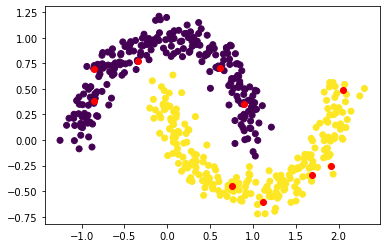

In [18]:
X,labels = datasets.make_moons(n_samples=500,noise=0.1)
W = gl.weightmatrix.knn(X,10,symmetrize=False)


train_ind = gl.trainsets.generate(labels, rate=5)
print(train_ind.size)
train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
pred_labels = model.fit_predict(train_ind, train_labels)

accuracy = gl.ssl.ssl_accuracy(pred_labels, labels, len(train_ind))   
print("Accuracy: %.2f%%"%accuracy)

plt.scatter(X[:,0],X[:,1], c=pred_labels)
plt.scatter(X[train_ind,0],X[train_ind,1], c='r')
plt.show()

[ 2.08166817e-17 -1.51788304e-17]
[[ 1.45153451 -1.45153451]
 [ 1.02019631 -1.02019631]
 [-0.11477777  0.11477777]
 [-0.9307856   0.9307856 ]
 [-0.86892368  0.86892368]
 [-0.88633912  0.88633912]
 [ 0.66892767 -0.66892767]
 [-0.97292179  0.97292179]
 [ 1.03808479 -1.03808479]
 [-0.67058996  0.67058996]
 [-0.52841068  0.52841068]
 [ 1.12552873 -1.12552873]
 [-0.67947604  0.67947604]
 [-1.08676752  1.08676752]
 [ 1.4575222  -1.4575222 ]
 [ 0.08139966 -0.08139966]
 [-0.10677601  0.10677601]
 [ 0.5774043  -0.5774043 ]
 [ 0.63510616 -0.63510616]
 [-0.25551928  0.25551928]]


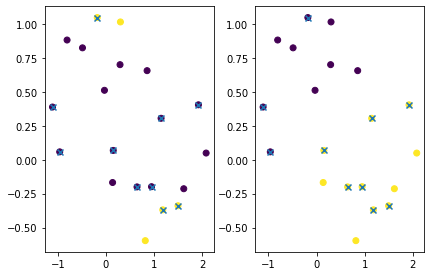

In [62]:
n = 20
k = 2

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]
m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
u = gradient_ppoisson(W, train_ind, y, p = 2)
pred_labels = predict(u)

fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

ax[0].scatter(X[:,0],X[:,1], c=pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')

train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')
plt.show()

477.1030565939509 0.12499995235704557


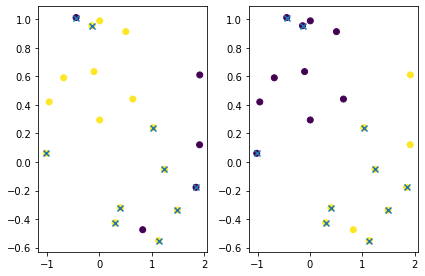

In [67]:
n = 20
k = 2

X,labels = datasets.make_moons(n_samples=n,noise=0.1)
W = gl.weightmatrix.knn(X,10).toarray()

train_ind = gl.trainsets.generate(labels, rate=5)
train_labels = labels[train_ind]

fig, ax = plt.subplots(ncols = 2)
fig.tight_layout()

train_labels = labels[train_ind]

model = gl.ssl.poisson(W, solver='gradient_descent')
u = model.fit(train_ind, train_labels)
pred_labels = predict(u)
ax[1].scatter(X[:,0],X[:,1], c=pred_labels)
ax[1].scatter(X[train_ind,0],X[train_ind,1], marker='x')


m = train_ind.size

y = np.zeros((m, k))
for i in range(train_ind.size):
    y[i] = euclidean_basis(train_labels[i], k)
    
my_u = started_gradient_ppoisson(W, train_ind, y, 2, u.flatten())
pred_labels = predict(my_u)
print(penergy(u.flatten(), W, train_ind, y, p), penergy(my_u.flatten(), W, train_ind, y, p))

ax[0].scatter(X[:,0],X[:,1], c=pred_labels)
ax[0].scatter(X[train_ind,0],X[train_ind,1], marker='x')

plt.show()

In [58]:
u = np.array([11, 12, 13, 21, 22, 23, 31, 32, 33, 41, 42, 43])
print(u)
print(u.reshape(4,3))

[11 12 13 21 22 23 31 32 33 41 42 43]
[[11 12 13]
 [21 22 23]
 [31 32 33]
 [41 42 43]]
